In [1]:
from pyspark.context import SparkContext # required for reading input dataset. (data preprocessing step)
import matplotlib.pyplot as plt # required for plotting. (Task 1.d)
import pandas as pd # required for plotting histograms. (Tasks 1.d, 8)
import pyspark.sql.functions as F # required for aggregating functions: min, max, mean, count, size, collect_list, isnan

from pyspark.sql.functions import lit, col, udf # col is required for renaming aggregated columns & count for plotting histograms. (Task 3.b) udf is required for counting tokens (Task 8.a)
from pyspark.ml.feature import Tokenizer, RegexTokenizer # required for tokenization. (Task 8.a)
from pyspark.sql.types import ArrayType,IntegerType, DoubleType # required for counting tokens. (Task 8.a)
from pyspark.ml import Pipeline, PipelineModel
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, HashingTF, IDF # required for removing stop words (Task 8.b)
from pyspark.ml.classification import NaiveBayes, LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics, MultilabelMetrics
from pyspark.sql import Window, Row
from handyspark import *
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

# required for plotting. (Task 3.b)
%matplotlib inline

In [17]:
#=================
#Common variables:
#=================

# Display records configuration:
#-------------------------------
numOfTopRecords = 10 # Default number of top records to display
minimalNumOfTopRecords = 2 # Minimum number of top records to display

# Cynical words configuration
#-----------------------------
minimalNumOfPositiveWords = 14 # The minimum number of positive words to filter in,for considering a word as cynical
maximumNumOfNegativeWords = 2 # The maximun number of negative words to filter in, for considering a word as cynical

# Histogram configuration
#------------------------
numOfBinsInHistogramOfContinueosValues = 100


# Classifiers configuration:
#---------------------------
shift = 1 # classification algorithms will name the class, by the index. But the minimal score is 1, so the indices should be shifted by 1 unit.
scores = [1,2,3,4,5] # Possible scores - these are the labels of the classifiers.
randomSplit = [0.7, 0.3] # The split ration of the dataset. First element for traning set, and second element for test set.

# Sampling records configuration:
#--------------------------------
numOfSamplingDefaultRecords = 10000
numOfSamplingBadRecords = 10
numOfSamplingCynicalRecords = 6

# TF & TF-IDF configuration:
#---------------------------
tfNumOfFeatures = 1000
minDocFreq = 6

# Grid param (cross validation) configuration:
#---------------------------------------------
numOfFolds = 3
smoothingGridParam = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
numOfFeaturesGridParam = [1000, 5000, 10000]
regGridParam = [0.1, 0.3, 0.5, 0.01, 0.03, 0.05]
elasticNetGridParam = [0.0, 0.1, 0.2]
maxIterGridParam = [10, 20, 50]
crossValidationParallelism = 8

# Seed configuration:
#--------------------
filterWordsSeed = 41
dataSplitSeed = 1234
clusterSeed = 42
sampleRecordsSeed = 47


#=================
#Common functions:
#=================

# Display the dash character ('-') for a given length times
def displayMultipleDashes(title, length):
    print('-' * length)

# Display title, with dash decoration
def displayTitle(title):
    length = len(title)
    print("\n")
    displayMultipleDashes(title, length)
    print(title)
    displayMultipleDashes(title, length)
    print("\n")
    
# Display title, with dash decoration
def displaySubTitle(title):
    length = len(title)
    print("\n")
    print(title)
    displayMultipleDashes(title, length)
    print("\n")
    

#===================
#Histogram functions:
#===================
    
# Get aggregated data frame of a given column, and the suitable count.
# Parameters:
# df - data frame
# columnName - name of column to aggregate
# columnAlias - alternative name of the columnName
# Returns:
# aggregated data frame, with 2 columns: alias column, and the suitable count frequiencies column.
def getAggregatedDfCount(df, columnName, columnAlias):
    return df.groupBy(columnName).agg(F.size(F.collect_list(columnName))).select(col(columnName).alias(columnAlias), col("size(collect_list(" + columnName + "))").alias("count"))

# Analyze column which contains continueous values, and display a histogram.
# aggregated_df - data frame with 2 columns: column and column count.
# pandas_df - aggregated_df converted to pandas dataframe.
# columnName - name of column to analyze, in aggregated_df
# columnAlias - name of column to analyze, in columnAlias
# recordName - name of record, which represents the original rows in aggregated_df
# numOfBins - number of bins to display in the histogram
def analyzeContinuousValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBins):
    
    # Show top records with highest frequencies.
    print("\ntop " + repr(numOfTopRecords) + " " + columnAlias + "s with maximum number of " + recordName + "s:")
    aggregated_df.orderBy("count", ascending=False).show(numOfTopRecords)
    
    # Show top records with lowest frequencies.
    print("\n " + repr(numOfTopRecords) + " " + columnAlias + "s with minimum number of " + recordName + "s:")
    aggregated_df.orderBy("count").show(numOfTopRecords)

    # Create histogram plot.
    pandas_df.plot.hist(grid=True, bins=numOfBins, rwidth=1, color='#607c8e')
    plt.title('Products reviews')
    plt.xlabel("#" + recordName + "s")
    plt.ylabel(columnAlias + "s")
    plt.title("Histogram of number of " + recordName + "s per " + columnAlias)
    plt.grid(axis='y', alpha=0.75)
    
    # Plot histogram.
    plt.show()
    
# Analyze column which contains descrete values, and display a bar graph.
# aggregated_df - data frame with 2 columns: column and column count.
# pandas_df - aggregated_df converted to pandas dataframe.
# columnName - name of column to analyze, in aggregated_df
# columnAlias - name of column to analyze, in columnAlias
# recordName - name of record, which represents the original rows in aggregated_df
# numOfBins - number of bins to display in the bar graph
def analyzeDescreteValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBins):   
    # Force convertion of alias column to int type, if conversion fails - don't throw erroes
    pandas_df[columnAlias] = pd.to_numeric(pandas_df[columnAlias], errors='coerce').astype(int)
    
    # Sort alias column in descending order.
    pandas_df.sort_values(by=[columnAlias], inplace=True)
    
    # Remove index column (for diaplay purposes)
    blankIndex=[''] * len(pandas_df)
    pandas_df.index=blankIndex
    
    # Display frequncies of alias column.
    display(pandas_df.nlargest(numOfBins,columns=columnAlias))
    
    # Create bar plot
    pandas_df.plot(kind='bar',x=columnAlias,y='count')
    
    # Plot bar graph
    plt.show()

# Analyze column values frequencies, and plot the results.
# Parameters:
# df - dataframe
# columnName - name of column in df to analyze
# columnAlias - alternative name of the columnName. Will be used for display purposes.
# recordName - name of record, which represents the original rows in df
# columnType - 0 - for descrete values, 1 - for continuous values
def analyzeColumn(df, columnName, columnAlias, recordName, columnType):
    displayTitle("Analyze " +  columnName + " column")
    
    # group df by columnName as columnAlias.
    aggregated_df = getAggregatedDfCount(df, columnName, columnAlias)
    
    # Convert df to pandas data frame.
    pandas_df = aggregated_df.toPandas()
    
    # Check if current column contains descrere values or continueous values 
    if columnType == 0: # descrete values column
        #  analyze descrete column & plot bar graph
        analyzeDescreteValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, columnCountDict[columnName])
    else: # columnType == 1 ==> continuous values column
        #  analyze continuous column & plot histogram
        analyzeContinuousValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBinsInHistogramOfContinueosValues)
    
    # Release unused memory
    del pandas_df

In [3]:
displayTitle("Loading the data:")
dataset_file = "Reviews.csv"
negative_words_file = "negative-words.txt"
positive_words_file = "positive-words.txt"


# Raise an error, if dataset does not exist
# The dataset can be downloaded from this url: https://www.kaggle.com/qwikfix/amazon-recommendation-dataset/data
# The expected path of the dataset, should be in the same directory of this jupyter notebook file.
if not os.path.exists(dataset_file):
    raise ValueError('Dataset file %s does not exist' % dataset_file)
    
# Raise an error, if negative words file does not exist
if not os.path.exists(negative_words_file):
    raise ValueError('negative words file %s does not exist' % negative_words_file)
    
# Raise an error, if positive words file does not exist
if not os.path.exists(positive_words_file):
    raise ValueError('positive words file %s does not exist' % positive_words_file)

print("Load the dat set from: " + dataset_file)
reviews = sc.textFile(dataset_file)

print("Load negative words from: " + negative_words_file)
negative_words_df = spark.read.option("header", "false")\
    .option("delimiter", "\n")\
    .csv(negative_words_file)

print("Load positive words from: " + positive_words_file)
positive_words_df = spark.read.option("header", "false")\
    .option("delimiter", "\n")\
    .csv(positive_words_file)

print("Data has been successfully loaded.")



-----------------
Loading the data:
-----------------


Load the dat set from: Reviews.csv
Load negative words from: negative-words.txt
Load positive words from: positive-words.txt
Data has been successfully loaded.


In [4]:
displayTitle("Preparing the data:")

print("extract header")
header = reviews.first()

print("Get columns titles")
columnsTitles = header.split(',')

# Fill dictionary of column -> index
columnsDict = {}
for column in columnsTitles:
    columnsDict[column] = columnsTitles.index(column)

# Save original reviews rdd with columns titles, before filtering.
original_reviews = reviews

# Filter out headers from reviews rdd.
reviews = reviews.filter(lambda row: row != header)

# Get number of columns, based on columns titles length
numOfColumns = len(columnsTitles)

print("Filter out corrupted records, with invalid number of columns")
reviews = reviews.filter(lambda p: len(p.split(",")) == numOfColumns)

print("get reviews rdd")
reviews_rdd = reviews.map(lambda line: line.split(","))

print("get reviews data frame")
reviews_df = reviews_rdd.toDF(columnsTitles)


displaySubTitle("Tokenization")

# define tokenizer, with words pattern
regexTokenizer = RegexTokenizer(inputCol="Text", outputCol="words", pattern="\\W")

# define tokens counter.
countTokens = udf(lambda words: len(words), IntegerType())

# Tokenize reviews_df
regexTokenized = regexTokenizer.transform(reviews_df)

# Select the tokenized Text column
tokenizedData = regexTokenized.select("Id", "Score", "Text", "words").withColumn("tokens", countTokens(col("words")))

print("Stop word removal:\n")

print("Get list of stop words to be removed, using StopWordsRemover")
listOfWords = StopWordsRemover.loadDefaultStopWords("english")

print("Define remover, with the list of stop words that have been loaded")
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=listOfWords)

print("Remove stop words")
filteredData = remover.transform(tokenizedData)

print("Add count_filtered column & cast Score column from Double to Integer")
filteredData = filteredData.withColumn("count_filtered", countTokens(col("filtered"))) \
                    .withColumn("Score", filteredData["Score"].cast(IntegerType()))

print("Display results, after removing stop words")
print("Every row's results will be displayed in the following format: Id|Score||Text|words|tokens|filtered|")
filteredData.show()



-------------------
Preparing the data:
-------------------


extract header
Get columns titles
Filter out corrupted records, with invalid number of columns
get reviews rdd
get reviews data frame


Tokenization
------------


Stop word removal:

Get list of stop words to be removed, using StopWordsRemover
Define remover, with the list of stop words that have been loaded
Remove stop words
Add count_filtered column & cast Score column from Double to Integer
Display results, after removing stop words
Every row's results will be displayed in the following format: Id|Score||Text|words|tokens|filtered|
+---+-----+--------------------+--------------------+------+--------------------+--------------+
| Id|Score|                Text|               words|tokens|            filtered|count_filtered|
+---+-----+--------------------+--------------------+------+--------------------+--------------+
|  1|    5|I have bought sev...|[i, have, bought,...|    48|[bought, several,...|            23|
|  2| 



------
Task 1
------




Task1.a
-------


Get avarage length of review (and more statistical data):

Avarage number of words in review, before words removal & tokenization: 42.27881088173079 words.
Avarage number of words in review, after stop words removal & tokenization: 20.804328326237716 words.
Maximum number of words in review, before words removal & tokenization: 286 words.
Minimum number of words in review, before words removal & tokenization: 1 words.


Task1.b
-------


We should use Text column, in order to predict score column


Task1.c
-------


Check if there is missing data:
In the input data set there is no missing data.


Task1.d
-------


Check exceptions in reviews:
In oredr to understand the exceptional lengths in the reviews, we will display a histograms of reviews length, before and after cleaning the data


Histogram of reviews length before cleaning the data
----------------------------------------------------




---------------------
Analyze tokens column
--

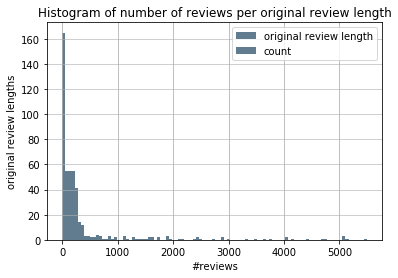



Histogram of reviews length after cleaning the data
---------------------------------------------------




-----------------------------
Analyze count_filtered column
-----------------------------



top 10 filtered review lengths with maximum number of reviews:
+----------------------+-----+
|filtered review length|count|
+----------------------+-----+
|                    12| 9397|
|                    13| 9147|
|                    14| 8890|
|                    11| 8559|
|                    15| 8120|
|                    16| 7611|
|                    10| 7380|
|                    17| 6685|
|                    18| 6304|
|                     9| 5426|
+----------------------+-----+
only showing top 10 rows


 10 filtered review lengths with minimum number of reviews:
+----------------------+-----+
|filtered review length|count|
+----------------------+-----+
|                   194|    1|
|                   231|    1|
|                   136|    1|
|                   142|   

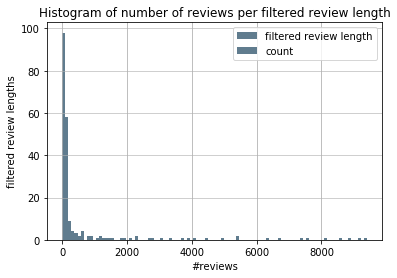

In addition to histograms display, we will explore exceptional length, using the magic_percentile method.
Scores grouped by percentiles review length:
+-----+--------------------------------------+
|score|review length magic percentiles values|
+-----+--------------------------------------+
|5    |[35, 17, 10, 7, 5, 1, 1]              |
|4    |[38, 17, 10, 7, 5, 4, 4]              |
|3    |[41, 18, 10, 6, 5, 3, 3]              |
|2    |[41, 18, 10, 7, 4, 4, 4]              |
|1    |[40, 19, 10, 7, 5, 1, 1]              |
+-----+--------------------------------------+

Short review frequencies found.
Short reviews occuur in the data set at a frequency of '0.0001'
Short Review lengths to be filtered (ordered by index of the suitable score)
[1, 4, 3, 4, 1]
Filter out short reviews


In [5]:
displayTitle("Task 1")

displaySubTitle("Task1.a")
print("Get avarage length of review (and more statistical data):\n")

mean_words_len = filteredData.agg(F.mean("tokens"))
mean_filtered_words_len = filteredData.agg(F.mean("count_filtered"))

print("Avarage number of words in review, before words removal & tokenization: " + repr(mean_words_len.head()[0]) + " words.")
print("Avarage number of words in review, after stop words removal & tokenization: " + repr(mean_filtered_words_len.head()[0]) + " words.")

max_words_len = filteredData.agg(F.max("count_filtered"))
min_words_len = filteredData.agg(F.min("count_filtered"))
print("Maximum number of words in review, before words removal & tokenization: " + repr(max_words_len.head()[0]) + " words.")
print("Minimum number of words in review, before words removal & tokenization: " + repr(min_words_len.head()[0]) + " words.")


displaySubTitle("Task1.b")
print("We should use Text column, in order to predict score column")


displaySubTitle("Task1.c")
print("Check if there is missing data:")

missing_text_count = reviews_df.filter((reviews_df["Text"] == "") | reviews_df["Text"].isNull() | F.isnan(reviews_df["Text"])).count()

if missing_text_count == 0 :
    print("In the input data set there is no missing data.")
else:
    print("There are " + repr(missing_text_count) + " reviews with missing text")
    
displaySubTitle("Task1.d")
print("Check exceptions in reviews:")

print("In oredr to understand the exceptional lengths in the reviews, we will display a histograms of reviews length, before and after cleaning the data")

displaySubTitle("Histogram of reviews length before cleaning the data")
analyzeColumn(filteredData, "tokens", "original review length", 'review', 1)
displaySubTitle("Histogram of reviews length after cleaning the data")
analyzeColumn(filteredData, "count_filtered", "filtered review length", 'review', 1)


print("In addition to histograms display, we will explore exceptional length, using the magic_percentile method.")

print("Scores grouped by percentiles review length:")
grp_window = Window.partitionBy('score')
magic_percentiles_values = '0.9, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001'
magic_percentile_alias = 'review length magic percentiles values'
magic_percentile = F.expr('percentile_approx(count_filtered, array(' + magic_percentiles_values + '))')
magic_percentile_score_reviews_length_df = filteredData.groupBy('score').agg(magic_percentile.alias(magic_percentile_alias)).orderBy("score", ascending=False)
magic_percentile_score_reviews_length_df.show(truncate = False)

magic_percentiles = [row[0] for row in magic_percentile_score_reviews_length_df.select(magic_percentile_alias).collect()]
m = len(magic_percentiles)
n = len(magic_percentiles[0])
is_duplicate_column = False

for j in range(n - 1):
    counter = 0
    for i in range(m):
        if magic_percentiles[i][j] != magic_percentiles[i][j + 1]:
            break
    if i == m - 1:
        is_duplicate_column = True
        break

short_review_frequency = magic_percentiles_values.split(", ")[j]
if is_duplicate_column:
    print("Short review frequencies found.")

print("Short reviews occuur in the data set at a frequency of " + repr(short_review_frequency))
irrelevant_review_length_list = []
for magic_percentile in magic_percentiles:
    irrelevant_review_length_list.append(magic_percentile[j])
    
print("Short Review lengths to be filtered (ordered by index of the suitable score)")
print(irrelevant_review_length_list)

print("Filter out short reviews")
cleanData = filteredData.rdd.filter(lambda line: line['count_filtered'] >  irrelevant_review_length_list[int(line['Score']) - 1]).toDF()



---------------------------------------------------------------------------------------
In this section, we try to look for corellation between negative words and score column
---------------------------------------------------------------------------------------


We will try to find correlation between negative words in the text column and the score column
For this purpose, we will use the StopWordsRemover mechanism, in order to filter out negative words from the filtered text (filtered, because stop words have already been removed)
Get list of negative words
Get list of positive words
Define negative words remover, with the list of negative words
We use the StopWordsRemover mechanism to filter out negative words
Define poswitive words remover, with the list of positive words
We use the StopWordsRemover mechanism to filter out positive words
Remove negative words
Remove positive words
Display results, after removing negative & positive words
Every row's results will be displayed in

'\nThe plot shows that there is no correlation between negative words and score.\nTherefore we should choose a different model for predicting score, based on text column\n'

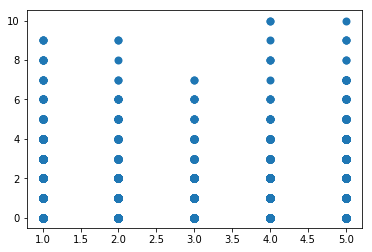

In [6]:
displayTitle("In this section, we try to look for corellation between negative words and score column")
print("We will try to find correlation between negative words in the text column and the score column")
print("For this purpose, we will use the StopWordsRemover mechanism, in order to filter out negative words from the filtered text (filtered, because stop words have already been removed)")

print("Get list of negative words")
negative_words_list = [row._c0 for row in negative_words_df.collect()]

print("Get list of positive words")
positive_words_list = [row._c0 for row in positive_words_df.collect()]

print("Define negative words remover, with the list of negative words")
print("We use the StopWordsRemover mechanism to filter out negative words")
negative_remover = StopWordsRemover(inputCol="words", outputCol="negative_filtered", stopWords=negative_words_list)

print("Define poswitive words remover, with the list of positive words")
print("We use the StopWordsRemover mechanism to filter out positive words")
positive_remover = StopWordsRemover(inputCol="words", outputCol="positive_filtered", stopWords=positive_words_list)

print("Remove negative words")
cleanDataWithoutNegativeWords = negative_remover.transform(cleanData).withColumn("count_negative_filtered", countTokens(col("negative_filtered")))

print("Remove positive words")
cleanDataWithoutPositiveWords = positive_remover.transform(cleanDataWithoutNegativeWords).withColumn("count_positive_filtered", countTokens(col("positive_filtered")))

cleanDataWithoutNegativeAndPositiveWords = cleanDataWithoutPositiveWords.select("Id", "Score", "Text", "tokens", "negative_filtered", "count_negative_filtered", "positive_filtered", "count_positive_filtered") \
            .withColumn("Score", cleanDataWithoutNegativeWords["Score"].cast(IntegerType())) \
            .withColumn("count_negative", col("tokens") - col("count_negative_filtered")) \
            .withColumn("count_positive", col("tokens") - col("count_positive_filtered"))

print("Display results, after removing negative & positive words")
print("Every row's results will be displayed in the following format: |Id|Score|Text|words|tokens|filtered|count_filtered|negative_filtered|count_negative_filtered|positive_filtered|count_positive_filtered|")
cleanDataWithoutNegativeAndPositiveWords.show()

print("Sample " + repr(numOfSamplingDefaultRecords) + " records, in order to check for a possible correlation bwtween negative words and score")
num_of_records = cleanDataWithoutNegativeAndPositiveWords.count()
percentage = 1 if num_of_records < numOfSamplingDefaultRecords else numOfSamplingDefaultRecords / num_of_records
df_pandas = cleanDataWithoutNegativeAndPositiveWords.sample(False, percentage, filterWordsSeed).toPandas()
plt.scatter(df_pandas['Score'], df_pandas['count_negative'],  lineWidth = 2.0)

'''
The plot shows that there is no correlation between negative words and score.
Therefore we should choose a different model for predicting score, based on text column
'''

In [7]:
displayTitle("Task1.e")
displaySubTitle("Examples of cynical and bad Reviews:")
'''

Negative reviews identification strategy:
-----------------------------------------
It's easy - we just filter in all of the reviews with the lowest score (1).
These reviews must be negative, because of their poor score.

Cynical text identification strategy:
-------------------------------------
Usually, cynical review wiil have a low score small amount of negative words.
The positive words will criticise the product, and present it in a negative way.
Therefore, out of the reviews with bad scores,
we filter in reviews with many positive words,
but just a few negative words (at most).
Hopefully, this approach will discover the cynical reviews.

'''

def df_sample_to_list(df, df_count, num_of_sampling_records, column1, column1Alias, column2, column2Alias):
    percentageRecords = 1.0 if df_count < num_of_sampling_records else num_of_sampling_records / df_count
    sample_list = [{column1Alias: x[column1], column2Alias: x[column2]} \
                    for x in df.sample(False, percentageRecords, sampleRecordsSeed).limit(num_of_sampling_records).collect()]
    return sample_list

def print_sample_list(sample_list, title, column1, column2):
    displaySubTitle(repr(len(sample_list)) + " " + title + ":")
    for row in sample_list:
        print("{}: {}".format(row['id'], row['text']))

badReviewsDF = cleanDataWithoutNegativeAndPositiveWords.rdd.filter(lambda line: line['Score'] ==  1).toDF()
cynicalReviewsDF = badReviewsDF.rdd.filter(lambda line: line['count_negative'] <= maximumNumOfNegativeWords and line['count_positive'] > minimalNumOfPositiveWords).toDF()

numBadReviewRecords = badReviewsDF.count()
numCynicalReviewRecords = cynicalReviewsDF.count()

print(repr(numBadReviewRecords) + " examples of bad reviews:")
badReviewsDF.show()

print("Out of the bad reviews, there are " + repr(numCynicalReviewRecords) + " examples of reviews that are probably cynical:")
cynicalReviewsDF.show()
    
bad_reviews_list =  df_sample_to_list(badReviewsDF, numBadReviewRecords, numOfSamplingBadRecords, 'Id', 'id', 'Text', 'text')
print_sample_list(bad_reviews_list, 'random bad reviews', 'id', 'text')

cynical_reviews_list =  df_sample_to_list(cynicalReviewsDF, numCynicalReviewRecords, numOfSamplingCynicalRecords, 'Id', 'id', 'Text', 'text')
print_sample_list(cynical_reviews_list, 'random cynical reviews', 'id', 'text')



-------
Task1.e
-------




Examples of cynical and bad Reviews:
------------------------------------


13405 examples of bad reviews:
+---+-----+--------------------+------+--------------------+-----------------------+--------------------+-----------------------+--------------+--------------+
| Id|Score|                Text|tokens|   negative_filtered|count_negative_filtered|   positive_filtered|count_positive_filtered|count_negative|count_positive|
+---+-----+--------------------+------+--------------------+-----------------------+--------------------+-----------------------+--------------+--------------+
|  2|    1|"Product arrived ...|    32|[product, arrived...|                     31|[product, arrived...|                     32|             1|             0|
| 63|    1|Arrived in 6 days...|    17|[arrived, in, 6, ...|                     16|[arrived, in, 6, ...|                     17|             1|             0|
| 76|    1|No tea flavor at ...|    19|[no, tea, flavor,...|   



5 random cynical reviews:
-------------------------


169392: Once upon a time this was such a wonderful product.<br /><br />The old Chocolate Twizzlers were much stronger in many ways. Taste yes and also in product 'behavior'.... The old product was 'tough' to pull apart... it actually had a 'snap' to it... This new 'stuff' behaves more like play-dough -- really 'squishy' and not in a good way. :)<br /><br />All I want to know is who is responsible for such a blunder and have they been fired yet? (kidding / well sorta)<br /><br />Dave<br /><br />Okay... I can't believe they (may have) actually listened!  I got a letter from Nestle back in Dec 2011 that they've reversed their changes to this great product and to look for new packages that have the tag line NOW WITH THE CLASSIC TWIST...  Well being in the middle of a home sale / purchase and all that goes along with that ... Chocolate Twizzlers weren't at the top of my priority... However now I'm going out to find a bag with the new t

In [8]:
displayTitle("Task2 (a+b)")
'''
Type of model:
-------------
There is no need to predict a binary answer (positive or negative review), since the score column is provided.
Therefore, the score will be predicted based on the Text.
It means that this is a classification problem with 5 classes.
'''



-----------
Task2 (a+b)
-----------




'\nType of model:\n-------------\nThere is no need to predict a binary answer (positive or negative review), since the score column is provided.\nTherefore, the score will be predicted based on the Text.\nIt means that this is a classification problem with 5 classes.\n'

In [9]:
displaySubTitle("Task3")

'''
3.a Evaluation method:
Confusion matrix - https://towardsdatascience.com/model-evaluation-techniques-for-classification-models-eac30092c38b

The correct classification will be determined by the Score column.

-------------------
|True    |False   |
|Positive|Positive|
-------------------
|False   |True    |
|Negative|Negative|
-------------------


Accuarcy = (TP + TN) / (TP + TN + FP + FN)
Precission = TP / (TP + FP)
Recall = Sensitivity = TP / (TP + FN)

Accuarcy - how often is the model correct?
Precission - When the model predicts positive results, how often is it correct?
Recall - When it is actually the positive result, how often does it predict correctly?


In our case it's not a binary classification problem, but a multi-class classification problem.
Therefore the conusion matrix dimensions are: 5X5
Where the main diaogonal is the TP values.

All of the column (excluding TP values) are FN
All of the rows (excluding TP values) are FP

We have 5 classes that represents a given score: 1,2,3,4,5

The total number of test examples of any class,
would be the sum of the corresponding row (i.e the TP+FN for that class)

The total number of FN's for a class,
is the sum of values in the corresponding row (excluding the TP)

The total number of FP's for a class,
is the sum of values in the corresponding column (excluding the TP)

The total number of TN's for a class,
is the sum of all columns and rows, exluding that class' column and row

The Recall, commonly called sensitivity,
corespponds to the true-positive-rate of the considered class.




                        PREDICTED
         |--------------------------------------------
ACTUAL   |   1        2        3        4        5
       1 | TP[1]     E[1,2]   E[1,3]   E[1,4]   E[1,5]
       2 | E[2,1]    TP[2]    E[2,3]   E[2,4]   E[2,5]
       3 | E[3,1]    E[3,2]   TP[3]    E[3,4]   E[3,5]
       4 | E[4,1]    E[4,2]   E[4,3]   TP[4]    E[4,5]
       5 | E[5,1]    E[5,2]   E[5,3]   E[5,4]   TP[5]


Precision 1 = TP[1] / (TP[1] + E[2,1] + E[3,1] + E[4,1] + E[5,1])
Precision 2 = TP[2] / (TP[2] + E[1,2] + E[3,2] + E[4,2] + E[5,2])
Precision 3 = TP[3] / (TP[3] + E[1,3] + E[2,3] + E[4,3] + E[5,3])
Precision 4 = TP[4] / (TP[4] + E[1,4] + E[2,4] + E[3,4] + E[5,4])
Precision 5 = TP[5] / (TP[5] + E[1,5] + E[2,5] + E[3,5] + E[4,5])


Recall 1 = Sensitivity 1 = TP[1] / (TP[1] + E[1,2] + E[1,3] + E[1,4] + E[1,5])
Recall 2 = Sensitivity 2 = TP[2] / (TP[2] + E[2,1] + E[2,3] + E[2,4] + E[2,5])
Recall 3 = Sensitivity 3 = TP[3] / (TP[3] + E[3,1] + E[3,2] + E[3,3] + E[3,4])
Recall 4 = Sensitivity 4 = TP[4] / (TP[4] + E[4,1] + E[4,2] + E[4,3] + E[4,5])
Recall 5 = Sensitivity 5 = TP[5] / (TP[5] + E[5,1] + E[5,2] + E[5,3] + E[5,4])


3.b Features to be used:
Text column

3.c Model description:
A classifier that predict score (5 possible classes), based on text column (vectorized)

'''




Task3
-----




"\n3.a Evaluation method:\nConfusion matrix - https://towardsdatascience.com/model-evaluation-techniques-for-classification-models-eac30092c38b\n\nThe correct classification will be determined by the Score column.\n\n-------------------\n|True    |False   |\n|Positive|Positive|\n-------------------\n|False   |True    |\n|Negative|Negative|\n-------------------\n\n\nAccuarcy = (TP + TN) / (TP + TN + FP + FN)\nPrecission = TP / (TP + FP)\nRecall = Sensitivity = TP / (TP + FN)\n\nAccuarcy - how often is the model correct?\nPrecission - When the model predicts positive results, how often is it correct?\nRecall - When it is actually the positive result, how often does it predict correctly?\n\n\nIn our case it's not a binary classification problem, but a multi-class classification problem.\nTherefore the conusion matrix dimensions are: 5X5\nWhere the main diaogonal is the TP values.\n\nAll of the column (excluding TP values) are FN\nAll of the rows (excluding TP values) are FP\n\nWe have 5 c

In [10]:
displayTitle("Task4")
displaySubTitle("Vectorization of reviews")

print("Building binary hashing TF")
binaryHashingTF = HashingTF().setNumFeatures(tfNumOfFeatures).setInputCol("filtered").setOutputCol("rawFeatures").setBinary(True)
binary_tf = binaryHashingTF.transform(cleanData)
print("Binary vectors of text as features:")
binary_tf.show(2, truncate=False)

print("\n================================================================================================================\n")

print("Building hashing TF (non-binary)")
hashingTF = HashingTF().setNumFeatures(tfNumOfFeatures).setInputCol("filtered").setOutputCol("rawFeatures")
tf = hashingTF.transform(cleanData)
print("Vectors of text as features (non-binary):")
tf.show(2, truncate=False)

print("\n================================================================================================================\n")

print("Building TF-IDF")
idf = IDF().setInputCol("rawFeatures").setOutputCol("features").setMinDocFreq(minDocFreq)
idfModel = idf.fit(tf)
tfidf = idfModel.transform(tf)
print("TF-IDF features:")
tfidf.show(2, truncate=False)



-----
Task4
-----




Vectorization of reviews
------------------------


Building binary hashing TF
Binary vectors of text as features:
+---+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+------------------------------------------------------------------

TF-IDF features:
+---+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------

In [11]:
displayTitle("Task5")
displaySubTitle("Splitting the data to train & test set with (0.7,0.3) ratio")

print("Selecting score & feature columns")
binary_tf_labeled = binary_tf.select('Score', 'rawFeatures') \
            .withColumn("Score", tf["Score"].cast(IntegerType())) \
            .withColumnRenamed("Score", "label") \
            .withColumnRenamed("rawFeatures", "features")
tf_labeled = tf.select('Score', 'rawFeatures') \
            .withColumn("Score", tf["Score"].cast(IntegerType())) \
            .withColumnRenamed("Score", "label") \
            .withColumnRenamed("rawFeatures", "features")
tfidf_labeled = tfidf.select('Score', 'features') \
            .withColumn("Score", tfidf["Score"].cast(IntegerType())) \
            .withColumnRenamed("Score", "label")

print("Splitting binart tf vectors to train & test sets")
train_set_binary_tf, test_set_binary_tf = binary_tf_labeled.randomSplit(randomSplit, seed=dataSplitSeed)

print("Splitting tf vectors to train & test sets")
train_set_tf, test_set_tf = tf_labeled.randomSplit(randomSplit, seed=dataSplitSeed)

print("Splitting tf-idf vectors to train & test sets")
train_set_tfidf, test_set_tfidf = tfidf_labeled.randomSplit(randomSplit, seed=dataSplitSeed)



-----
Task5
-----




Splitting the data to train & test set with (0.7,0.3) ratio
-----------------------------------------------------------


Selecting score & feature columns
Splitting binart tf vectors to train & test sets
Splitting tf vectors to train & test sets
Splitting tf-idf vectors to train & test sets


In [15]:
def classifyData(classifier, train_set, test_set, paramGrid):

    # Create 3-fold CrossValidator
    cv = CrossValidator(estimator = nb,
                        estimatorParamMaps = paramGrid,
                        evaluator = MulticlassClassificationEvaluator(),
                        numFolds = numOfFolds,
                        parallelism = crossValidationParallelism)

    # Run cross validations
    cvModel = cv.fit(train_set)

    # Predict data, based on the best model from cross-validation
    predictions = cvModel.transform(test_set)
    
    # Make prediction and test accuracy
    predictionsAndLabelsDF = predictions.select('label', 'prediction') \
    .withColumn("label", predictions["label"].cast(DoubleType()))

    # Convert predictionsAndLabels to rdd format
    if shift != 0:
        predictionsAndLabelsDF = predictionsAndLabelsDF.withColumn("prediction", predictions["prediction"] + shift)
    predictionsAndLabelsRDD = predictionsAndLabelsDF.rdd

    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionsAndLabelsRDD)
    
    return metrics

def evaluateClassifier(metrics):    
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)

    # Statistics by class
    for label in sorted(scores):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

    # Confusion matrix
    confusionMatrix = metrics.confusionMatrix()
    np.set_printoptions(formatter={'float': '{: 0.0f}'.format})
    print("confusionMatrix:")
    print(confusionMatrix)
    print("Confusion Matrix Values:")
    print(confusionMatrix.values)

In [16]:
displayTitle("Task6")
displaySubTitle("Run classifiers on TF vectors, and evaluate the results")

print("Set Naive Bayes classifier")
nb = NaiveBayes(smoothing=1.0, modelType='multinomial', featuresCol='features', labelCol='label')

print("Set Logistic Regression classifier")
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, labelCol = 'label')

print("Create ParamGrid for Cross Validation of naive bayes, with TF vectors")
nbTfParamGrid = (ParamGridBuilder()
               .addGrid(nb.smoothing, smoothingGridParam)
               .addGrid(hashingTF.numFeatures, numOfFeaturesGridParam) # Number of features
               .build())

print("Create ParamGrid for Cross Validation of naive bayes, with TF-IDF vectors")
nbTfIdfParamGrid = (ParamGridBuilder()
               .addGrid(nb.smoothing, smoothingGridParam)
               .build())

print("Create ParamGrid for Cross Validation, with TF vectors")
lrTfParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regGridParam) # regularization parameter
             .addGrid(lr.elasticNetParam, elasticNetGridParam) # Elastic Net Parameter (Ridge = 0)
             .addGrid(hashingTF.numFeatures, numOfFeaturesGridParam) # Number of features
             .addGrid(lr.maxIter, maxIterGridParam) #Number of iterations
             .build())

print("Create ParamGrid for Cross Validation, with TF-IDF vectors")
lrTfIdfParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regGridParam) # regularization parameter
             .addGrid(lr.elasticNetParam, elasticNetGridParam) # Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, maxIterGridParam) #Number of iterations
             .build())

print("\nRun naive bayes with binary TF vectors ...")
nb_binary_tf_metrics = classifyData(nb, train_set_binary_tf, test_set_binary_tf, nbTfParamGrid)

print("\nRun naive bayes with TF vectors (non-binary) ...")
nb_tf_metrics = classifyData(nb, train_set_tf, test_set_tf, nbTfParamGrid)

print("\nRun logistic regression with binary TF vectors ...")
lr_binary_tf_metrics = classifyData(lr, train_set_binary_tf, test_set_binary_tf, lrTfParamGrid)

print("\nRun logistic regression with TF vectors (non-binary) ...")
lr_tf_metrics = classifyData(lr, train_set_tf, test_set_tf, lrTfParamGrid)

print("\n=========================================================================")
print("\nEvalute metrics of naive bayes with binary TF vectors")
evaluateClassifier(nb_binary_tf_metrics)
print("\n=========================================================================")

print("\nEvalute metrics of naive bayes with TF vectors (non-binary)")
evaluateClassifier(nb_tf_metrics)
print("\n=========================================================================")

print("\nEvalute metrics of logistic regression with binary TF vectors")
evaluateClassifier(lr_binary_tf_metrics)
print("\n=========================================================================")

print("\nEvalute metrics of logistic regression with TF vectors (non-binary)")
evaluateClassifier(lr_tf_metrics)
print("\n=========================================================================")





-----
Task6
-----




Run classifiers on TF vectors, and evaluate the results
-------------------------------------------------------


Set Naive Bayes classifier
Set Logistic Regression classifier
Create ParamGrid for Cross Validation of naive bayes, with TF vectors
Create ParamGrid for Cross Validation of naive bayes, with TF-IDF vectors
Create ParamGrid for Cross Validation, with TF vectors
Create ParamGrid for Cross Validation, with TF-IDF vectors

Run naive bayes with binary TF vectors ...

Run naive bayes with TF vectors (non-binary) ...

Run logistic regression with binary TF vectors ...

Run logistic regression with TF vectors (non-binary) ...


Evalute metrics of naive bayes with binary TF vectors
Summary Stats
Precision = 0.740008479682235
Recall = 0.740008479682235
Class 1 precision = 0.4969666329625885
Class 1 recall = 0.5253874933190807
Class 2 precision = 0.1598870056497175
Class 2 recall = 0.34512195121951217
Class 3 precision = 0.1708407871198569
Class 3 recall = 0.35

In [ ]:
displayTitle("Task8")
displaySubTitle("Run classifiers on TF-IDF vectors, and evaluate the results")

print("\nRun naive bayes with TF-IDF vectors ...")
nb_tf_metrics = classifyData(nb, nb_shift, train_set_tfidf, test_set_tfidf, nbTfIdfParamGrid)

print("\nRun logistic regression with TF-IDF vectors ...")
lr_tf_metrics = classifyData(lr, lr_shift, train_set_tfidf, test_set_tfidf, lrTfIdfParamGrid)

print("\n=========================================================================")
print("\nEvalute metrics of naive bayes with TF-IDF vectors")
evaluateClassifier(nb_tf_metrics)
print("\n=========================================================================")

print("Evalute metrics of logistic regression with TF-IDF vectors")
evaluateClassifier(lr_tf_metrics)
print("\n=========================================================================")

In [ ]:
displayTitle("Task7")
displaySubTitle("Clustering the data")

'''
We will use k-means with k=2 clusters,
and try to find correlation between one cluster and negative reviews,
and a correlation between the second cluster and positive reviews.
'''

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
kmeansModel = kmeans.fit(train_set_tf)

# Make predictions
kmeansPredictions = kmeansModel.transform(test_set_tf)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(kmeansPredictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the clusters.
centers = kmeansModel.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Split the predictions data into 2 dataframes, based on the suitable cluster (0/1)
clusters_df = kmeansPredictions.select('label', 'prediction')
cluster_0_df = clusters_df.filter('prediction == 0')
cluster_1_df = clusters_df.filter('prediction == 1')

# Sample the 2 splitted dataframes and convert them to pandas data frame
print("Sample " + repr(numOfSamplingDefaultRecords) + " records, in order to check for a possible correlation between cluster_0 and the given scores")
num_of_cluster0_records = cluster_0_df.count()
cluster0_percentage = 1.0 if num_of_cluster0_records < numOfSamplingDefaultRecords else numOfSamplingDefaultRecords / num_of_cluster0_records
df_cluster0_pandas = cluster_0_df.sample(False, cluster0_percentage, clusterSeed).toPandas()
num_of_cluster1_records = cluster_1_df.count()
cluster1_percentage = 1.0 if num_of_cluster1_records < numOfSamplingDefaultRecords else numOfSamplingDefaultRecords / num_of_cluster1_records
df_cluster1_pandas = cluster_1_df.sample(False, cluster1_percentage, clusterSeed).toPandas()

# Plot 2 histograms of score & score count, corresponding to the 2 splitted dataframes.
fig, (left_plt, right_plt) = plt.subplots(ncols=2, figsize=(10, 5))
left_plt.hist(df_cluster0_pandas['label'],
         bins=scores,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)
left_plt.set_title("cluster_0")

right_plt.hist(df_cluster1_pandas['label'],
         bins=scores,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)
right_plt.set_title("cluster_1")

In [ ]:
displayTitle("Task9")
displaySubTitle("Comparing the clustering results with the classification results")
'''
From the histograms in task 8 we can conclude that there is no correlation between clusters and scores.
Therefore negative/positive reviews should not be classified based on these 2 clusters

on the other hand converting 5 score classes,
into 2 classes (negative/positive reviews) is straight forward.
Score 5 is classified as positive review
Score 4 is classified as positive review
Score 1 is classified as negative review
Score 2 is classified as negative review
Score 3 is classified as negative review (For the balance, since most of the scores are 5)

'''